# $H_2$ Energy Surface with XACC-VQE

To run this problem via docker, run the following from an empty directory

```bash
$ docker run --name xacc-notebook -it -p 8888:8888 -d -v $(pwd):/home/notebooks mccaskey/xacc-all-gate-jupyter-fc26
```

## Setup the Problem

In [1]:
import sys, os
sys.path.append('/usr/local/xacc/lib/python')
import pyxacc as xacc
import pyxaccvqe as vqe
from pyxaccvqe import PauliOperator
from pyxacc import InstructionParameter
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD

# Initialize the framework 
xacc.Initialize()

# Create our Hamiltonian
H = PauliOperator('g0') + PauliOperator({0:'Z'},'g1') + PauliOperator({1:'Z'},'g2') \
	+ PauliOperator({0:'Z',1:'Z'},'g3') + PauliOperator({0:'Y',1:'Y'}, 'g4') \
	+ PauliOperator({0:'X',1:'X'},'g5')

# Read in the coefficient data as a function of R
h2coeffs = np.genfromtxt('h2_hamiltonian_data.csv', delimiter=',', names=['R', 'I', 'Z0', 'Z1', 'Z0Z1', 'Y0Y1', 'X0X1'])

# Construct some lists to detail the name of 
# the variable coefficients, and the columns in the data file
gs = ['g0', 'g1', 'g2', 'g3', 'g4', 'g5']
cols = ['I', 'Z0', 'Z1', 'Z0Z1', 'Y0Y1', 'X0X1']

# Map column name to variable name
gMap = {c:gs[i] for i,c in enumerate(cols)}

# Setup an empty options map, we will add to it for 
# VQE run after straight diagonalization run
# NOTE that default task is vqe-diagonalize and 
# default backend is Eigen. 
vqeOptions = {} 

print('Hamiltonian = ', H)

Hamiltonian =  (1,0) g5 X0 X1 + (1,0) g4 Y0 Y1 + (1,0) g2 Z1 + (1,0) g0 + (1,0) g3 Z0 Z1 + (1,0) g1 Z0


## Compute Energy Surface using Eigen Diagonalization

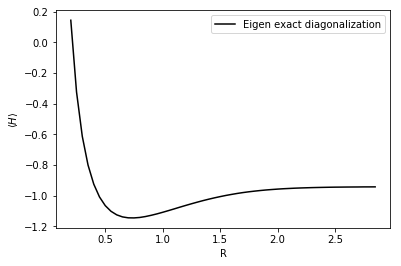

In [6]:
energies = []
# Loop over all R
for i, r in enumerate(h2coeffs['R']):
    
    # Construct the variable to coeff map
    varMap = {gMap[k]:h2coeffs[k][i] for k in cols}

    # Evaluate our Hamiltonian
    Heval = H.eval(varMap)

    # Execute - this diagonalizes the Hamiltonian 
    # and returns lowest eigenvalue
    e = vqe.execute(Heval, **vqeOptions)[0][1]
    energies.append(e)

import matplotlib.pyplot as plt
plt.xlabel(r'R')
plt.ylabel(r'$\langle H\rangle$')
plt.plot(h2coeffs['R'], energies, color='k', label='Eigen exact diagonalization')
plt.legend()
plt.show()

## Compute Energy Surface with VQE using TNQVM

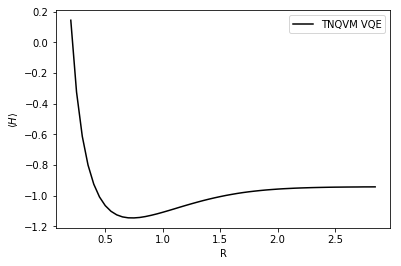

In [7]:
# Create the State Preparation Circuit for our VQE Run
statePrep = xacc.gate.GateFunction('statePrep', [InstructionParameter('theta')])
statePrep.add(xacc.gate.create('Rx',[0],[InstructionParameter(np.pi)]))
statePrep.add(xacc.gate.create('Ry',[1],[InstructionParameter(np.pi/2.)]))
statePrep.add(xacc.gate.create('Rx',[0],[InstructionParameter(7.8539752)]))
statePrep.add(xacc.gate.create('CNOT',[1,0]))
statePrep.add(xacc.gate.create('Rz',[0],[InstructionParameter('theta')]))
statePrep.add(xacc.gate.create('CNOT',[1,0]))
statePrep.add(xacc.gate.create('Ry',[1],[InstructionParameter(7.8539752)]))
statePrep.add(xacc.gate.create('Rx',[0],[InstructionParameter(np.pi/2.)]))

vqeOptions = {'task':'vqe', 'ansatz':statePrep} 

vqeenergies = []
# Loop over all R
for i, r in enumerate(h2coeffs['R']):
    
    # Construct the variable to coeff map
    varMap = {gMap[k]:h2coeffs[k][i] for k in cols}

    # Evaluate our Hamiltonian
    Heval = H.eval(varMap)

    # Execute - this diagonalizes the Hamiltonian 
    # and returns lowest eigenvalue
    e = vqe.execute(Heval, **vqeOptions)[0][1]
    vqeenergies.append(e)

import matplotlib.pyplot as plt
plt.xlabel(r'R')
plt.ylabel(r'$\langle H\rangle$')
plt.plot(h2coeffs['R'], vqeenergies, color='k', label='TNQVM VQE')
plt.legend()
plt.show()

## Finalize the Framework

In [10]:
xacc.Finalize()